In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

/Users/takeshi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


## 学習

In [2]:
df = pd.read_csv('train.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,52,services,married,secondary,no,108,yes,no,unknown,15,may,543,12,-1,0,unknown,no
1,35,admin.,married,unknown,no,1055,no,no,cellular,2,mar,59,2,-1,0,unknown,no
2,37,blue-collar,married,secondary,no,32,yes,no,unknown,20,may,146,2,-1,0,unknown,no
3,57,unemployed,married,primary,no,2743,no,no,cellular,29,jan,89,1,-1,0,unknown,no
4,42,self-employed,married,tertiary,no,6383,no,no,cellular,27,aug,111,5,-1,0,unknown,no


## データ確認
参考URL：https://ohke.hateblo.jp/entry/2017/08/04/230000

In [3]:
df['y'].value_counts()

no     35952
yes     4737
Name: y, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a3549b0>,
      dtype=object)

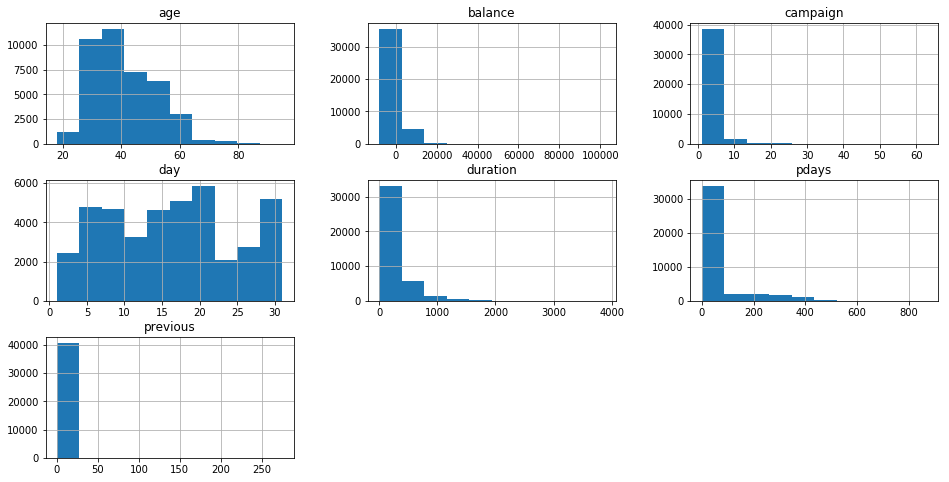

In [4]:
df.hist(figsize=(16,8))

In [6]:
# カテゴリ系の特徴量に含まれる値を確認
for col in df.columns:
    if not isinstance(df[col][0],str):
        continue
    print('({})'.format(col))
    print('{}'.format(np.unique(df[col].values)))

(job)
['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
(marital)
['divorced' 'married' 'single']
(education)
['primary' 'secondary' 'tertiary' 'unknown']
(default)
['no' 'yes']
(housing)
['no' 'yes']
(loan)
['no' 'yes']
(contact)
['cellular' 'telephone' 'unknown']
(month)
['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
(poutcome)
['failure' 'other' 'success' 'unknown']
(y)
['no' 'yes']


In [5]:
def create_feature_df(input_df):
    # 各特徴量の相関係数を可視化
    features_df = pd.DataFrame()

    # 目的変数
    features_df['y'] = input_df['y'].apply(lambda s : 1 if s == 'yes' else 0)

    # 連続値
    features_df['age'] = input_df['age']
    features_df['balance'] = input_df['balance']
    features_df['day'] = input_df['day']
    features_df['duration'] = input_df['duration']
    features_df['campaign'] = input_df['campaign']
    features_df['pdays'] = input_df['pdays']
    features_df['previous'] = input_df['previous']

    # ２値
    features_df['default'] = input_df['default'].apply(lambda s : 1 if s=='yes' else 0)
    features_df['housing'] = input_df['housing'].apply(lambda s : 1 if s=='yes' else 0)
    features_df['loan'] = input_df['loan'].apply(lambda s : 1 if s=='yes' else 0)

    # カテゴリ
    features_df['job'],_ = pd.factorize(input_df['job'])
    features_df['marital'],_ = pd.factorize(input_df['marital'])
    features_df['education'],_ = pd.factorize(input_df['education'])
    features_df['contact'],_ = pd.factorize(input_df['contact'])
    features_df['month'],_ = pd.factorize(input_df['month'])
    features_df['poutcome'],_ = pd.factorize(input_df['poutcome'])
    
    return features_df

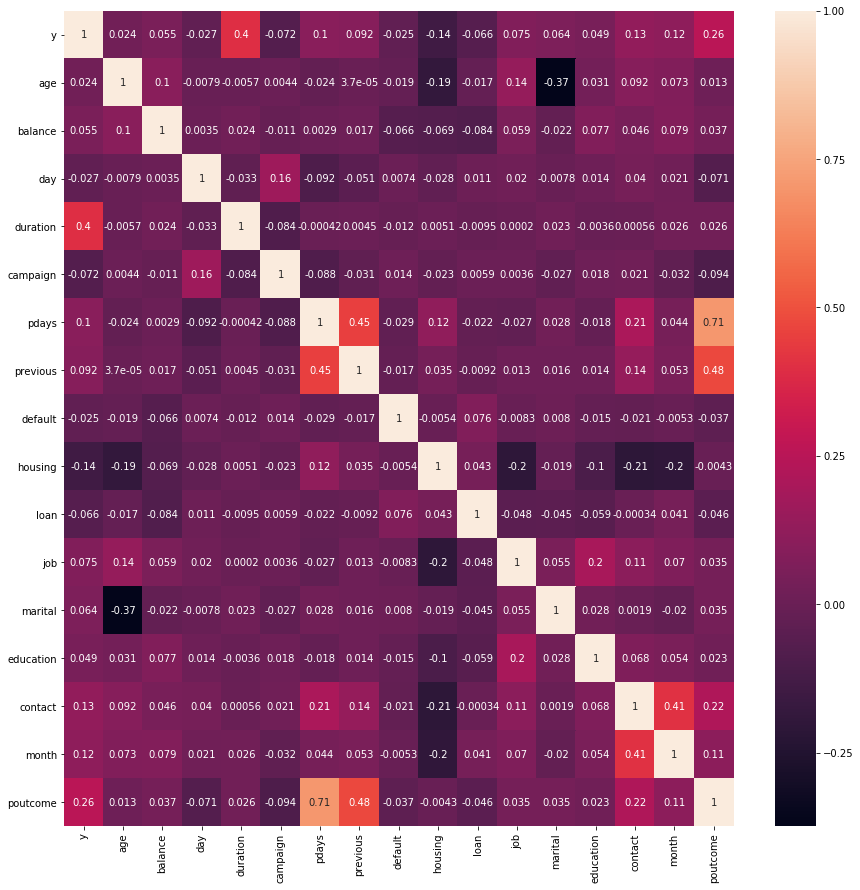

In [24]:
# やってみたけど名義尺度のカテゴリデータに対して相関係数は使えない
import seaborn 
plt.figure(figsize=(15,15))
seaborn.heatmap(create_feature_df(df).corr(), annot=True)

In [6]:
def get_features(df):
    # 特徴量として使う連続量
    features_ana = ['age', 'balance','day','duration','campaign','pdays','previous']
    # 連続値として使うカテゴリ値
    features_dig = ['job', 'housing','default','loan','marital','education','contact','month','poutcome']
    X = np.concatenate(
        [df[features_ana].values, pd.get_dummies(df[features_dig]).values],
        axis=1)
    return X

def get_label(df):
    y = df['y'].replace({'yes': 1, 'no': 0}).values
    return y

## モデル構築

In [9]:
def create_xgboost_model_and_fit(target_df):
    features_df = create_feature_df(target_df)
    X = features_df.drop('y',axis=1).values
    y = get_label(target_df)

    xgboost = GradientBoostingClassifier(random_state=0)
    xgboost.fit(X,y)
    # 評価
    print('Train score: {}'.format(xgboost.score(X, y)))
    #print('Test score: {}'.format(xgboost.score(X_test, y_test)))
    print('Confusion matrix:\n{}'.format(confusion_matrix(y, xgboost.predict(X))))
    print('f1 score: {:.3f}'.format(f1_score(y, xgboost.predict(X))))
    return xgboost

In [13]:
# 特徴量, ラベルを作成
X = get_features(df)
y = get_label(df)
xgboost = create_xgboost_model_and_fit(df)

Train score: 0.9090171790901718
Confusion matrix:
[[34979   973]
 [ 2729  2008]]
f1 score: 0.520


## テスト

In [14]:
test_df = pd.read_csv('test.csv')

In [15]:
test_X = create_feature_df(test_df).drop('y',axis=1).values
test_y = get_label(test_df)
print('Test score: {}'.format(xgboost.score(test_X, test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_y, xgboost.predict(test_X))))
print('f1 score: {:.3f}'.format(f1_score(test_y, xgboost.predict(test_X))))
pred_xgboost =xgboost.predict(test_X)
print(accuracy_score(test_y,pred_xgboost))

Test score: 0.8951791242812914
Confusion matrix:
[[3870  100]
 [ 374  178]]
f1 score: 0.429
0.8951791242812914


In [17]:
# 外れ値データを外したCSVファイルでやってみる
dropped_train_df = pd.read_csv('dropped_outliers_train.csv')
# 特徴量, ラベルを作成
X = get_features(dropped_train_df)
y = get_label(dropped_train_df)
xgboost_dropped = create_xgboost_model_and_fit(dropped_train_df)

# テスト
test_df = pd.read_csv('test.csv')
test_X = create_feature_df(test_df).drop('y',axis=1).values
test_y = get_label(test_df)
print('Test score: {}'.format(xgboost_dropped.score(test_X, test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_y, xgboost_dropped.predict(test_X))))
print('f1 score: {:.3f}'.format(f1_score(test_y, xgboost_dropped.predict(test_X))))
pred_xgboost =xgboost_dropped.predict(test_X)
print(accuracy_score(test_y,pred_xgboost))

Train score: 0.9087332808811959
Confusion matrix:
[[34974   964]
 [ 2748  1986]]
f1 score: 0.517
Test score: 0.8949579831932774
Confusion matrix:
[[3862  108]
 [ 367  185]]
f1 score: 0.438
0.8949579831932774


In [10]:
# accuracy
pred = model.predict(test_X).reshape(-1)
pred = (pred > 0.5).astype(int)

In [13]:
# test ARI (この値を報告してください)
accuracy_score(test_y, pred)

0.8781512605042017